# Algoritmos Evolutivos: Trabajo Práctico Nº3
Autores: Joaquín Matías Mestanza y Gonzalo Nicolas Silva Caggiano
## Ejercicio 1
Una fábrica produce cuatro tipos de partes automotrices. Cada una de ellas primero se fabrica y luego se le dan los acabados. Las horas de trabajador requeridas y la utilidad para cada parte son las siguientes:
 
| Parte                        | A   | B   | C    | D   |
|------------------------------|-----|-----|------|-----|
| Tiempo fabricacion (hr/100 u) | 2.5 | 1.5 | 2.75 | 2   |
| Tiempo acabados (hr/100 u)   | 3.5 | 3   | 3    | 2   |
| Utilidad ($/100 u)           | 375 | 275 | 475  | 325 |

Las capacidades de los talleres de fabricación y acabados para el mes siguiente son de 640 y 960 horas, respectivamente. Determinar mediante un algoritmo PSO con restricciones (sin usar bibliotecas para PSO) que cantidad de cada partes debe producirse a fin de maximizar la utilidad y resolver las siguientes consignas:

#### a y b. (Valor 0.33 puntos) Transcribir el algoritmo escrito en Python a un archivo .pdf de acuerdo a los siguientes parámetros: número de partículas = 20, máximo número de iteraciones 50, coeficientes de aceleración c1 = c2 = 1.4944, factor de inercia w = 0.6. Transcribir al .pdf la solución óptima encontrada (dominio) y el valor objetivo óptimo (imagen).

Tenemos 4 partes, por ende nuestro problema es 4 dimensional.


In [10]:
import numpy as np
# funcion objetivo a maximizar, utilidad ($/100 unidades)
def ej1_target_function(x):
    assert(len(x) == 4)
    utility = np.array([375, 275, 475, 325])
    return np.dot(utility,x)

# sujeto a:

def limite_fabricacion(x):
    assert(len(x) == 4)
    fabrication = np.array([2.5, 1.5, 2.75, 2])
    return np.dot(fabrication,  x) <= 640 # horas

def limite_acabados(x):
    assert(len(x) == 4) 
    finishing = np.array([3.5, 3, 3, 2])
    return np.dot(finishing, x) <= 960 # horas

def implicit_restriction(x):
    return all(el>0 for el in x)


from ejemplos.pso_restric_01 import pso

ej1_params = {
    "n_particles": 20,
    "n_dimensions": 4,
    "max_iterations": 50,
    "c1": 1.4944,
    "c2": 1.4944,
    "w": 0.6,
    "restrictions": [limite_acabados, limite_fabricacion, implicit_restriction],
    "target_function": ej1_target_function    
}

historic_gbest = pso(**{**ej1_params, "print_sol": True})

Mejor solucion: [34.83, 49.56, 47.7, 173.7]
Valor optimo: 105801.82002299462


#### c. (Valor 0.33 puntos) Indicar en el .pdf la URL del repositorio en donde se encuentra el algoritmo PSO.
Como el entregable es un ipynb se desestima este punto.


#### d. (Valor 0.5 puntos) Realizar un gráfico de línea que muestre gbest (eje de ordenadas) en función de las iteraciones realizadas (eje de abscisas). El gráfico debe contener etiquetas en los ejes, leyenda y un título. El gráfico debe ser pegado en el .pdf.

Text(0, 0.5, 'gbest')

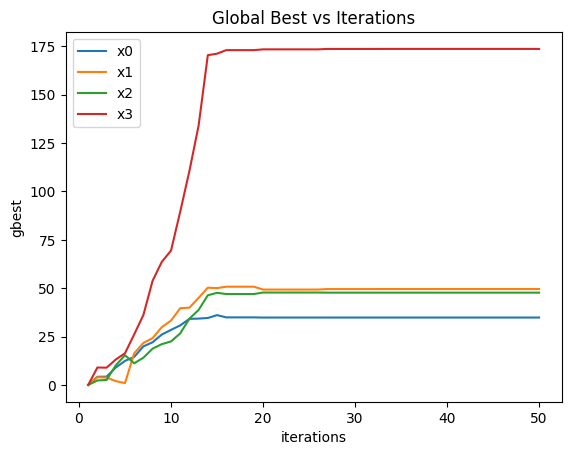

In [11]:
import matplotlib.pyplot as plt 
for i in range(ej1_params["n_dimensions"]):
    dimension_gbest = historic_gbest[:,i]
    plt.plot(range(1,1+len(dimension_gbest)),dimension_gbest, label=f'x{i}')
plt.legend()
plt.title('Global Best vs Iterations')
plt.xlabel('iterations')
plt.ylabel('gbest')

#### e. (Valor 0.5 puntos) Explicar (en el .pdf) y demostrar (desde el código fuente) que sucede si se reduce en 1 unidad el tiempo de acabado de la parte B.

Veamos como quedaria la tabla con todos los tiempos de acabado disminuidos en 1 unidad.
| Parte                        | A   | B   | C    | D   |
|------------------------------|-----|-----|------|-----|
| Tiempo fabricacion (hr/100 u) | 2.5 | 1.5 | 2.75 | 2   |
| Tiempo acabados (hr/100 u)   | 3.5 | 2   | 3    | 2   |
| Utilidad ($/100 u)           | 375 | 275 | 475  | 325 |



In [12]:
def new_limite_acabados(x):
    assert(len(x) == 4) 
    finishing = np.array([3.5, 2, 3, 2])
    return np.dot(finishing, x) <= 960 # horas

new_restrictions = [limite_fabricacion, new_limite_acabados, implicit_restriction]

executions = 1000

b_modified = []
b_original = []
for i in range(executions):
    gbest_original = pso(**{**ej1_params, "print_sol":False})    
    b_original.append(gbest_original[-1,1]) # -1 es el ultimo, 1 es la dimension (b)
    gbest_modified = pso(**{**ej1_params, "restrictions": new_restrictions, "print_sol": False})
    b_modified.append(gbest_modified[-1,1])


import pandas as pd
original_b_values = pd.DataFrame(b_original)
modified_b_values = pd.DataFrame(b_modified)

In [13]:
original_b_values.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,0
count,1000.00000
mean,73.04265
std,40.64023
min,0.00000
25%,46.42106
50%,73.50484
75%,97.19069
max,204.08159


In [14]:
modified_b_values.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,0
count,1000.00000
mean,76.20676
std,43.03598
min,0.00000
25%,49.19828
50%,74.48979
75%,99.17413
max,334.93122


Parece que en general tiende a crecer el valor de B despues de modificarlo. Esto tiene sentido ya que tiene una ponderacion menor, con lo cual debe usar un numero mas alto para llegar al mismo target.

#### f. (Valor 1 punto) Realizar 3 boxplots a partir de los gbest de 3 variantes de solución: i) El primer boxplot con el coeficiente de inercia constante w = 0.8, ii) El segundo boxplot con el coeficiente de inercia dinámico lineal y iii) El tercer boxplot sin coeficiente de inercia pero aplicando Factor de constricción con φ a elección.

Elegimos $\phi$=4.1 para asegurar convergencia

In [15]:
solutions_1 =[]
solutions_2 = []
solutions_3 = []
for i in range(30):
    first_model = pso(**{**ej1_params, "w": 0.8})
    solutions_1.append(first_model[-1])
    second_model = pso(**{**ej1_params, "w_algorithm": 'linear'})
    solutions_2.append(second_model[-1])
    third_model = pso(**{**ej1_params, "w_algorithm": 'constriction', "phi": 4.1})
    solutions_3.append(third_model[-1])
    
solutions_1 = np.array(solutions_1)
solutions_2 = np.array(solutions_2)
solutions_3 = np.array(solutions_3)

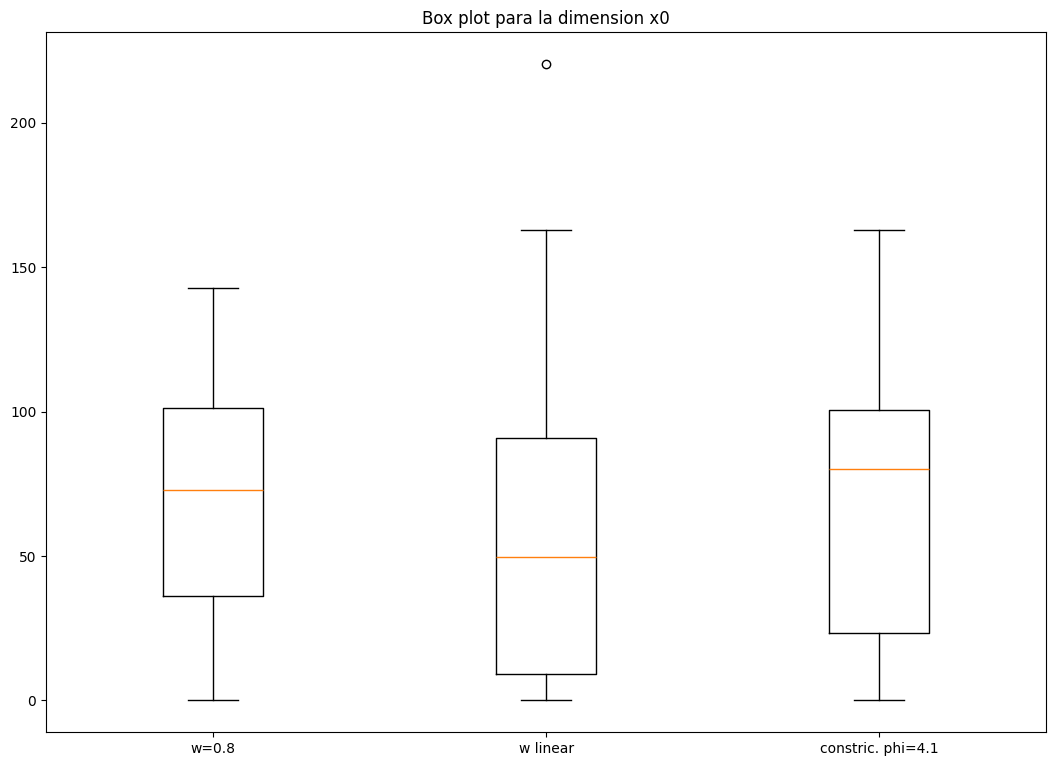

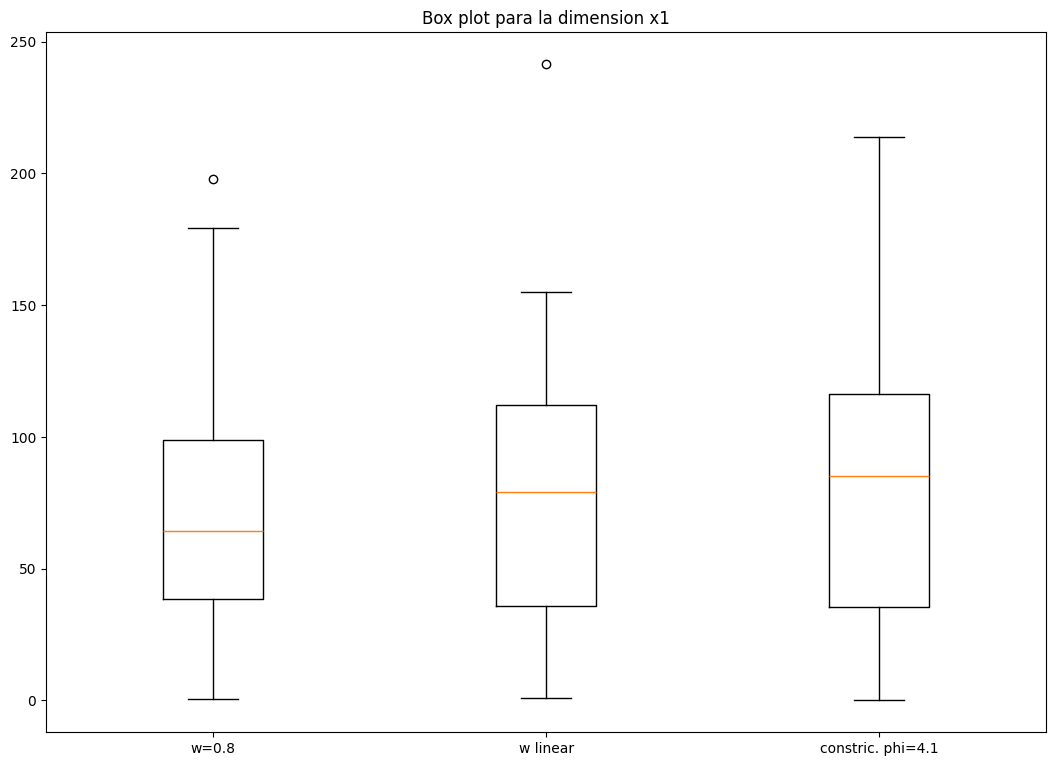

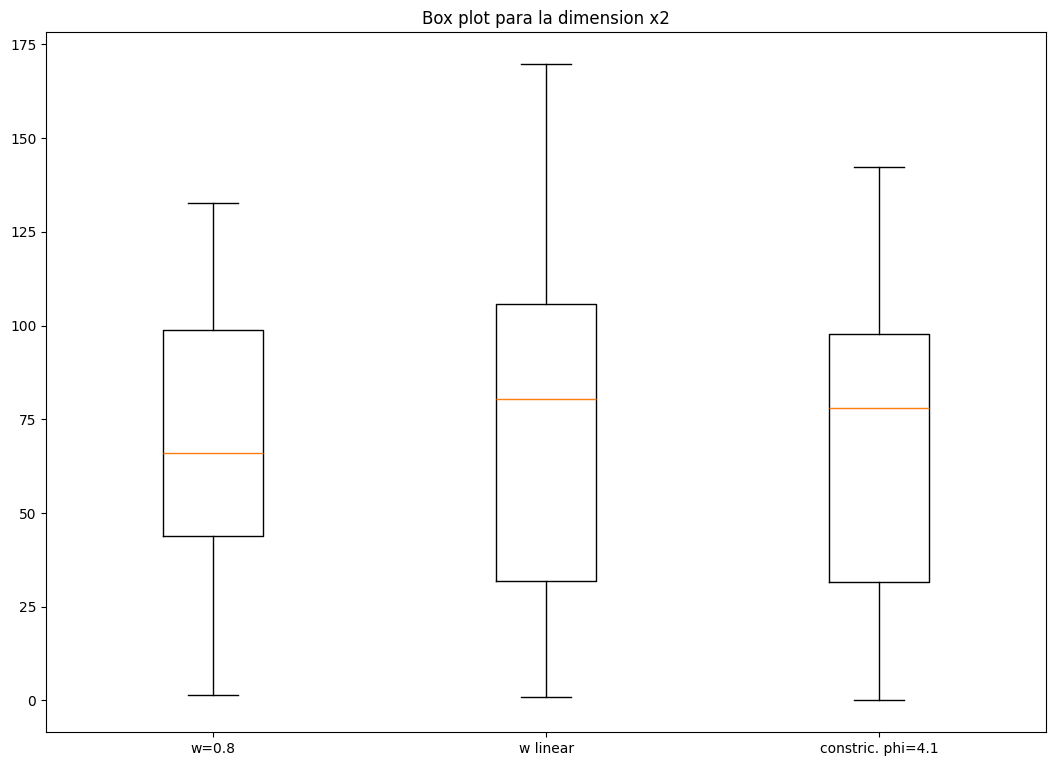

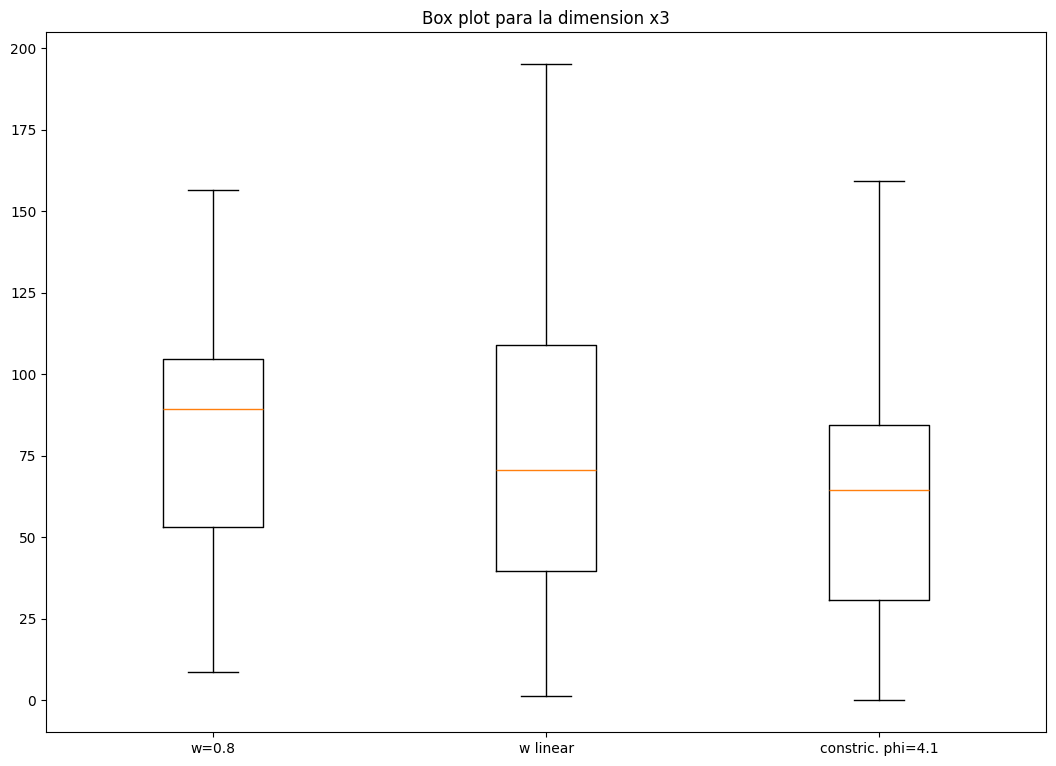

In [16]:
import matplotlib.pyplot as plt
for i in range(ej1_params["n_dimensions"]):
    data = [solutions_1[:,i], solutions_2[:,i], solutions_3[:,i]]
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_title(f'Box plot para la dimension x{i}')
    bp = ax.boxplot(data)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['w=0.8', 'w linear', 'constric. phi=4.1'])
# show plot
plt.show()

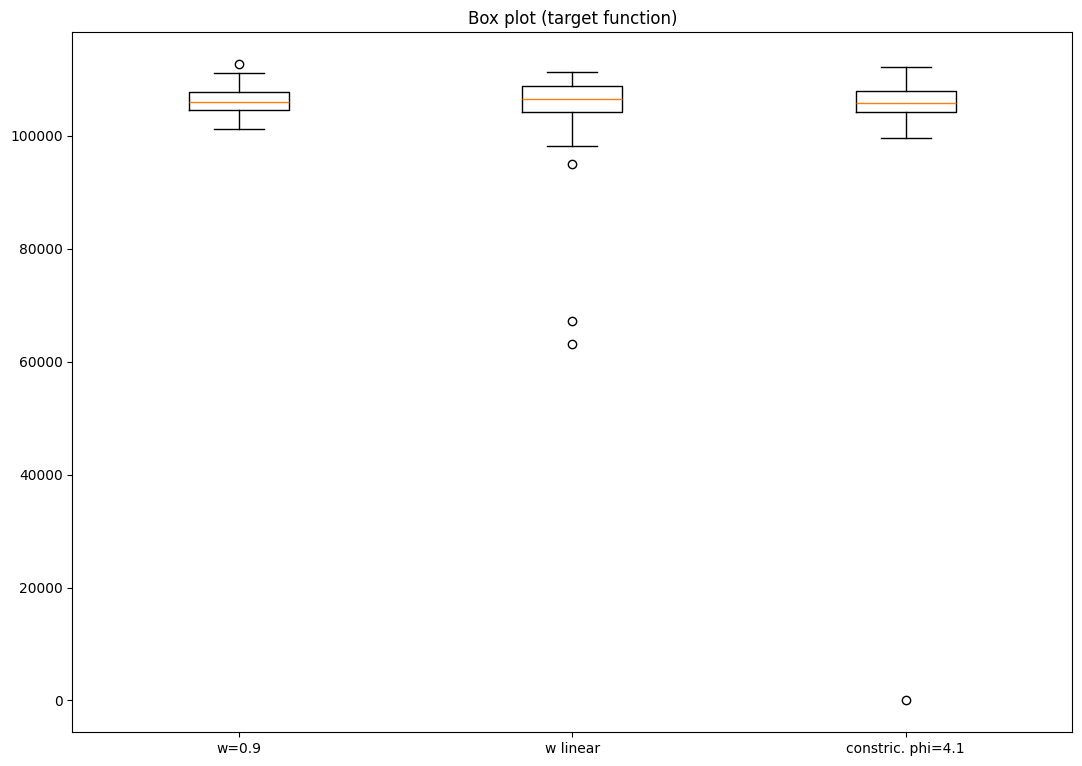

In [18]:
import matplotlib.pyplot as plt
tgt_1 = [ej1_params["target_function"](el) for el in solutions_1]
tgt_2 = [ej1_params["target_function"](el) for el in solutions_2]
tgt_3 = [ej1_params["target_function"](el) for el in solutions_3]
data = [tgt_1, tgt_2, tgt_3]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title(f'Box plot (target function)')
bp = ax.boxplot(data)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['w=0.9', 'w linear', 'constric. phi=4.1'])
# show plot
plt.show()

#### g. (Valor 1 punto) Realizar observaciones/comentarios/conclusiones en el .pdf acerca de los resultados del ítem (f).

En general ninguno de los 3 es superior a cualquiera de los otros (al menos en este problema en especifico). Los 3 modelos tienen la mediana y rangos intercuartilicos relativamente similares.

Sabiendo esta distribucion sobre los gbest, podriamos inicializar el algoritmo limitando las particulas en estos rangos de forma tal de mejorar la convergencia.

#### h. (Valor 1 punto) Realizar observaciones/comentarios/conclusiones en el .pdf acerca de qué cantidad mínima de partículas es factible utilizar para este problema específicamente.

Text(0.5, 0, 'particles')

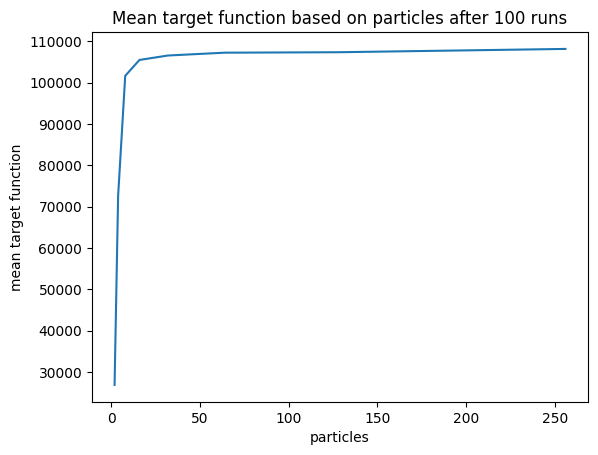

In [19]:
particle_group_mean = []
new_executions = 100
particle_array = [2<<i for i in range(8)] # probamos hasta 256 particulas
for particle_num in particle_array:
    target_per_particle_group = []
    for _ in range(new_executions):
        historic_gbest = pso(**{**ej1_params, "n_particles": particle_num, "print_sol":False})
        last_gbest = historic_gbest[-1]
        target_per_particle_group.append(ej1_params["target_function"](last_gbest))
    particle_group_mean.append(np.mean(target_per_particle_group))
plt.plot(particle_array, particle_group_mean)
plt.title('Mean target function based on particles after 100 runs')
plt.ylabel('mean target function')
plt.xlabel('particles')

Hemos dibujado el promedio de las funciones objetivo evaluadas con el gbest para 100 ejecuciones variando la cantidad de particulas exponencialmente con pontencias de 2 (1,2,4,8...) . 
Se puede observar que con 32 particulas es mas que suficiente ya que llegamos a un resultado bastante cercano al optimo.

## Ejercicio 2 

Un fabricante de equipos de cómputo produce dos tipos de impresoras (impresoras de tipo 1 e impresoras de tipo 2). Los recursos necesarios para producirlas así como las utilidades correspondientes son los que siguen:

|Equipo | Capital ($\$$/u) | Mano de obra (hs/u) | utilidad ($\$$/u) |
|-|------------------|---------------------|-------------------|
|Impresora 1| 300              | 20                  | 500               |
|Impresora 2| 400              | 10                  | 400               |


Si cada día se dispone de $127000 de capital y 4270 horas de mano de obra, ¿qué cantidad de cada equipo debe producirse a diario a fin de maximizar la utilidad? Escriba el algoritmo PSO con restricciones (sin usar bibliotecas para PSO) que permita optimizar la utilidad y resolver cumpliendo con las siguientes consignas:

#### a. (Valor 0.33 puntos) Transcribir el algoritmo escrito en Python a un archivo .pdf de acuerdo a los siguientes parámetros: número de partículas = 10, máximo número de iteraciones 80, coeficientes de aceleración c1 = c2 = 2, factor de inercia w = 0.5. b. (Valor 0.33 puntos) Transcribir al .pdf la solución óptima encontrada (dominio) y el valor objetivo óptimo (imagen).


In [20]:
def ej2_target_function(x):
    utility_factor = np.array([500,400])
    return np.dot(utility_factor,x)

def capital_restriction(x):
    capital_factor = np.array([300, 400]) 
    return np.dot(capital_factor, x) <= 127000

def mano_obra_restriction(x):
    mano_obra_factor = np.array([20,10])
    return np.dot(mano_obra_factor, x) <= 4270
    


ej2_params = {
    "n_dimensions": 2,
    "n_particles": 10,
    "max_iterations": 80,
    "c1": 2,
    "c2": 2,
    "w": 0.5,
    "restrictions": [capital_restriction, mano_obra_restriction, implicit_restriction],
    "target_function": ej2_target_function,
}


In [21]:
ej2_d = pso(**{**ej2_params, "print_sol": True})

Mejor solucion: [162.77, 101.47]
Valor optimo: 121970.02546479109


#### c. (Valor 0.33 puntos) Indicar en el .pdf la URL del repositorio en donde se encuentra el algoritmo PSO.
Como se entrega .ipynb se desestima este punto.

#### d. (Valor 1 punto) Realizar un gráfico de línea que muestre gbest (eje de ordenadas) en función de las iteraciones realizadas (eje de abscisas). El gráfico debe contener etiquetas en los ejes, leyenda y un título. El gráfico debe ser pegado en el .pdf.

Text(0, 0.5, 'gbest')

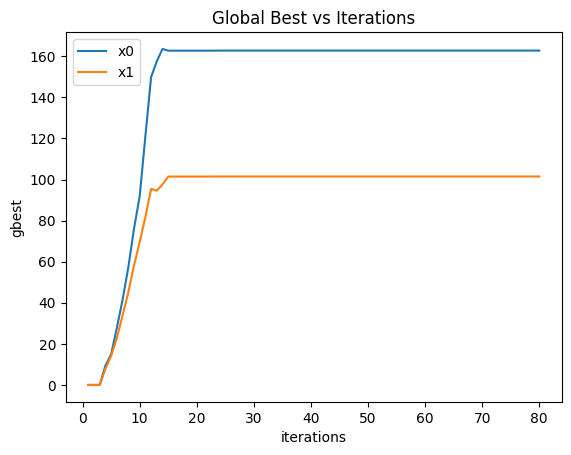

In [22]:
import matplotlib.pyplot as plt 
for i in range(ej2_params["n_dimensions"]):
    dimension_gbest = ej2_d[:,i]
    plt.plot(range(1,1+len(dimension_gbest)),dimension_gbest, label=f'x{i}')
plt.legend()
plt.title('Global Best vs Iterations')
plt.xlabel('iterations')
plt.ylabel('gbest')

#### e. (Valor 1 puntos) Realizar 3 boxplots a partir de los gbest de 3 variantes de solución: i) El primer boxplot con el coeficiente de inercia constante w = 0.9, ii) El segundo boxplot con el coeficiente de inercia dinámico lineal y iii) El tercer boxplot sin coeficiente de inercia pero aplicando Factor de constricción con φ = 5.

In [23]:
solutions_1 =[]
solutions_2 = []
solutions_3 = []
for i in range(30):
    first_model = pso(**{**ej2_params, "w": 0.9})
    solutions_1.append(first_model[-1])
    second_model = pso(**{**ej2_params, "w_algorithm": 'linear'})
    solutions_2.append(second_model[-1])
    third_model = pso(**{**ej2_params, "w_algorithm": 'constriction', "phi": 5})
    solutions_3.append(third_model[-1])
    
solutions_1 = np.array(solutions_1)
solutions_2 = np.array(solutions_2)
solutions_3 = np.array(solutions_3)

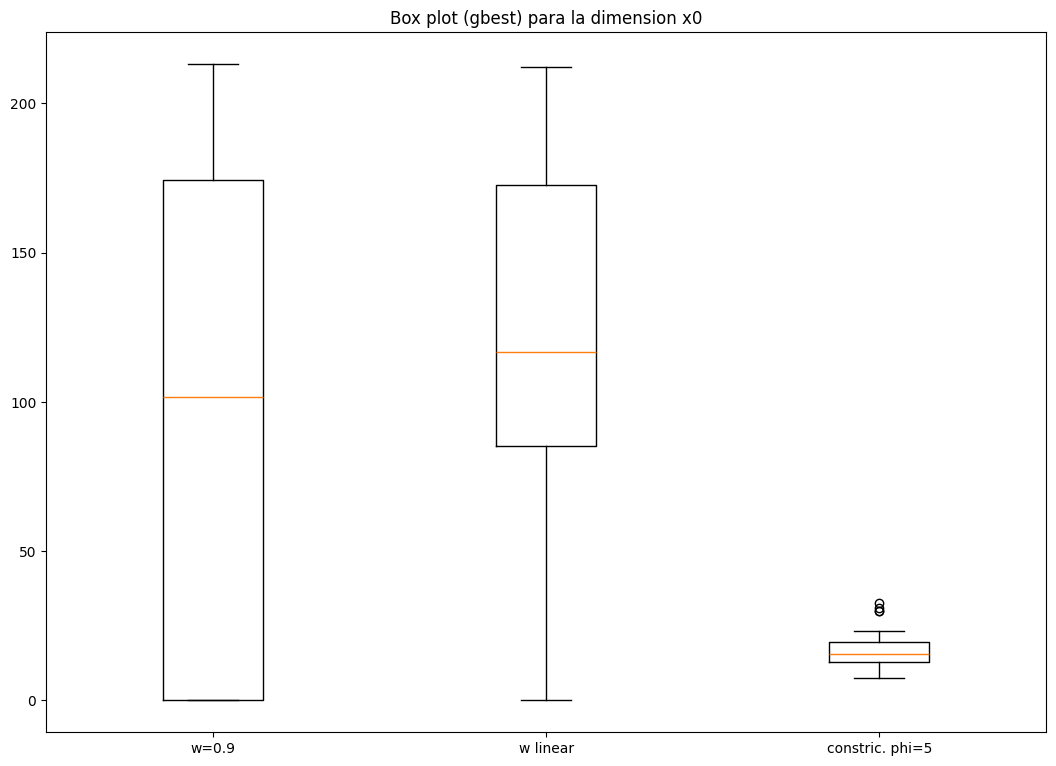

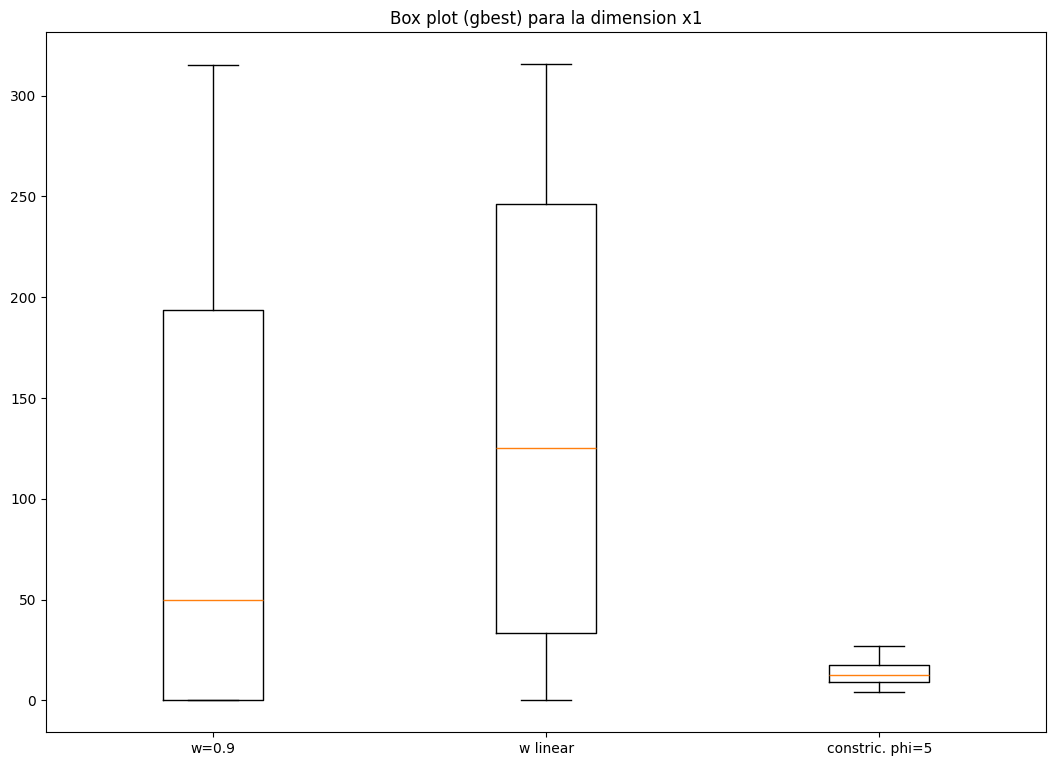

In [24]:
import matplotlib.pyplot as plt
for i in range(ej2_params["n_dimensions"]):
    data = [solutions_1[:,i], solutions_2[:,i], solutions_3[:,i]]
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_title(f'Box plot (gbest) para la dimension x{i}')
    bp = ax.boxplot(data)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['w=0.9', 'w linear', 'constric. phi=5'])
# show plot
plt.show()

#### f. (Valor 1 puntos) Realizar observaciones/comentarios/conclusiones en el .pdf acerca de los resultados del ítem (e).



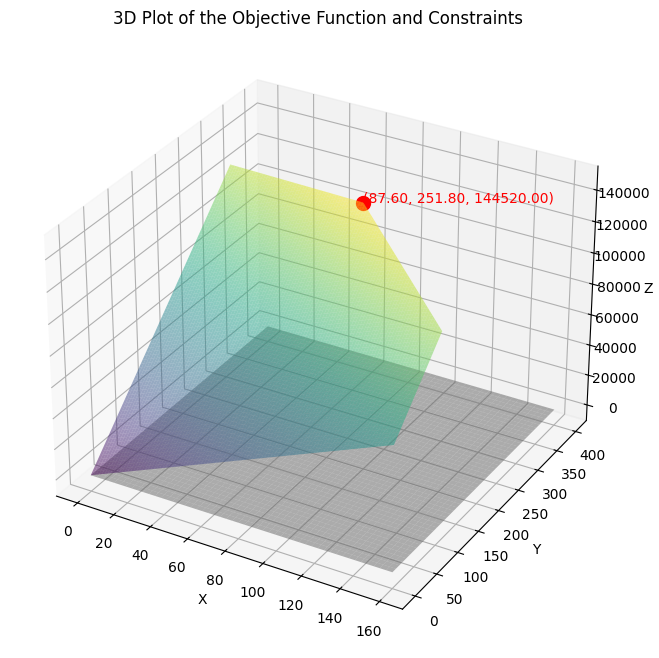

Optimal values: x = 87.60, y = 251.80, z = 144520.00


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# Define the constraints
def constraints(x, y):
    return (
        300 * x + 400 * y <= 127000,
        20 * x + 10 * y <= 4270,
        x >= 0,
        y >= 0
    )

# Generate the mesh grid for x and y
x = np.linspace(0, 160, 10000)
y = np.linspace(0, 400, 10000)
X, Y = np.meshgrid(x, y)

# Calculate Z based on the objective function
Z = 500 * X + 400 * Y

# Create a mask for the constraints
mask = (300 * X + 400 * Y <= 127000) & (20 * X + 10 * Y <= 4270) & (X >= 0) & (Y >= 0)

# Set values of Z outside the feasible region to NaN
Z[~mask] = np.nan

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, cmap='viridis')

# Create a ground plane (Z = 0)
Z_ground = np.zeros_like(X)
ax.plot_surface(X, Y, Z_ground, alpha=0.5, color='gray')  # Ground plane

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of the Objective Function and Constraints')

# Solve the linear programming problem
c = [-500, -400]  # Coefficients for z = 500x + 400y (negated for minimization)
A = [[300, 400], [20, 10]]
b = [127000, 4270]
x_bounds = (0, None)  # x >= 0
y_bounds = (0, None)  # y >= 0

# Solve the problem
result = linprog(c, A_ub=A, b_ub=b, bounds=[x_bounds, y_bounds], method='highs')

# Extract the optimal values
x_opt, y_opt = result.x
z_opt = 500 * x_opt + 400 * y_opt
# Plot the optimal point
ax.scatter(x_opt, y_opt, z_opt, color='red', s=100, label='Optimal Point')
ax.text(x_opt, y_opt, z_opt, f'({x_opt:.2f}, {y_opt:.2f}, {z_opt:.2f})', color='red')

plt.show()
print(f"Optimal values: x = {x_opt:.2f}, y = {y_opt:.2f}, z = {z_opt:.2f}")


chequeamos que cumplan las restricciones

In [26]:
capital_restriction([87.60, 251.80])

np.True_

In [27]:
mano_obra_restriction([87.60, 251.80])

np.True_

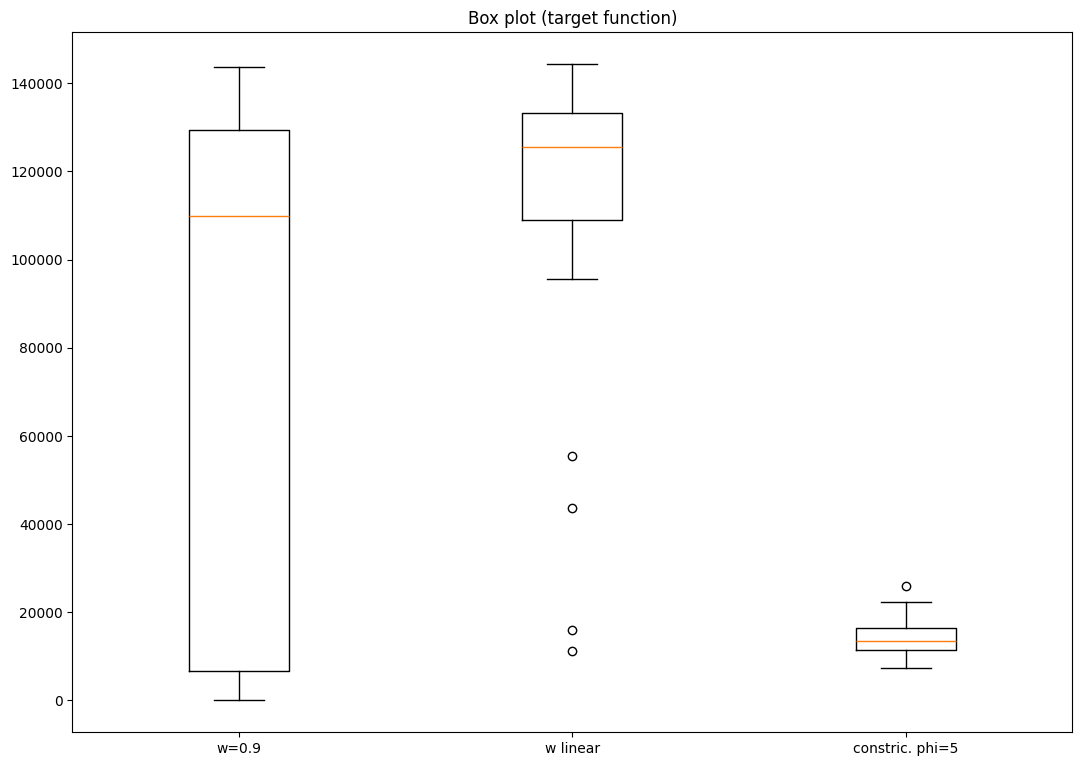

In [28]:
import matplotlib.pyplot as plt
tgt_1 = [ej2_target_function(el) for el in solutions_1]
tgt_2 = [ej2_target_function(el) for el in solutions_2]
tgt_3 = [ej2_target_function(el) for el in solutions_3]
data = [tgt_1, tgt_2, tgt_3]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title(f'Box plot (target function)')
bp = ax.boxplot(data)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['w=0.9', 'w linear', 'constric. phi=5'])
# show plot
plt.show()

Claramente el mas lejano fue el de factor de constriccion en este caso.
Si bien la convergencia es rapida y garantizada, no nos asegura que converge al optimo. Quiza si probaramos con un factor de constriccion cerca de 4.1, probablemnete nos de un mejor resultado.

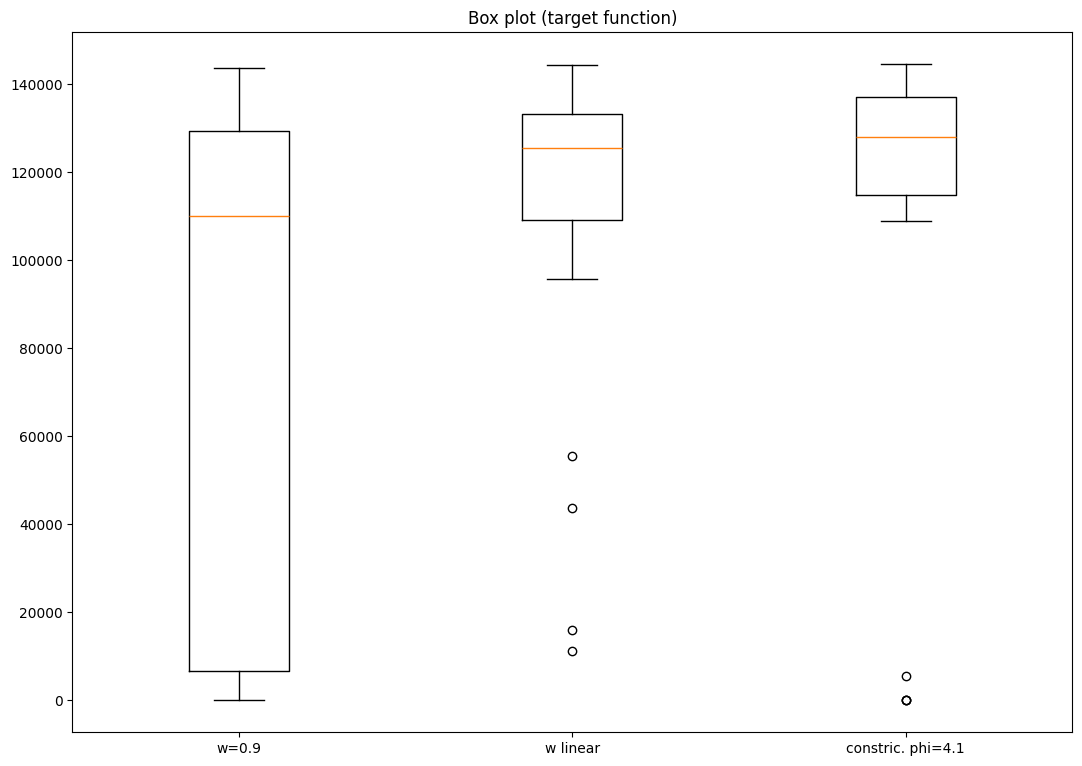

In [30]:
new_solutions_3 = [pso(**{**ej2_params, "w_algorithm": 'constriction', "phi": 4.1})[-1] for _ in range(30)]
import matplotlib.pyplot as plt
new_tgt_3 = [ej2_target_function(el) for el in new_solutions_3]
data = [tgt_1, tgt_2, new_tgt_3]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title(f'Box plot (target function)')
bp = ax.boxplot(data)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['w=0.9', 'w linear', 'constric. phi=4.1'])
# show plot
plt.show()

En efecto, el factor de constriccion juega un rol importantisimo en la convergencia del algoritmo. En este caso a pesar de que es menos rapido, converge a una mejor solucion. Y no solo eso, sino que el rango intercuartil esta mucho mas cerca que el resto de los algoritmos del optimo.

En este caso el peor de los 3 es el que posee w=0.9, al fijarnos el rango intercuartilico de la funcion objetivo, vemos que es el peor en el sentido de que es menos probable que nos de la solucion optima. 

#### g. (Valor 1 puntos) Realizar observaciones/comentarios/conclusiones en el .pdf acerca de qué cantidad mínima de partículas es factible utilizar para este problema específicamente.

En este caso si utilizamos el mejor de los 3 para tratar de buscar la cantidad minima de particulas.

Text(0.5, 0, 'particles')

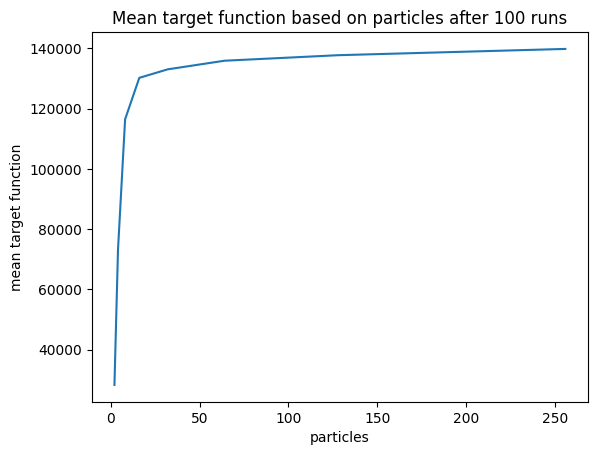

In [32]:
particle_group_mean = []
new_executions = 100
particle_array = [2<<i for i in range(8)] # probamos hasta 256 particulas
for particle_num in particle_array:
    target_per_particle_group = []
    for _ in range(new_executions):
        historic_gbest = pso(**{**ej2_params, "n_particles": particle_num, "print_sol":False, "w_algorithm": 'constriction', "phi": 4.1})
        last_gbest = historic_gbest[-1]
        target_per_particle_group.append(ej2_target_function(last_gbest))
    particle_group_mean.append(np.mean(target_per_particle_group))
plt.plot(particle_array, particle_group_mean)
plt.title('Mean target function based on particles after 100 runs')
plt.ylabel('mean target function')
plt.xlabel('particles')

In [50]:
idx = 5
total_particles = 2**idx
mean_tgt_fn_idx = particle_group_mean[idx]
z_optimo = 144520
print(f'Funcion objetivo promedio: {mean_tgt_fn_idx} para el caso de {total_particles} particulas')
print(f'representa un: {100*mean_tgt_fn_idx/z_optimo:.2f}% del optimo' )

Funcion objetivo promedio: 135876.4560645911 para el caso de 32 particulas
representa un: 94.02% del optimo


En este caso 94% del optimo nos representa una buena solucion suboptima, entonces se necesita de 32 particulas como minimo. 

Esto claramente depende del problema. Si el tiempo que nos lleva encontrar una solucion es demasiado grande (debido a que aumenta con la cantidad de particulas), entonces no justifica el costo del tiempo de computo. A decir verdad este es un problema relativamente acotado pero a medida que aumentan las dimensiones, esto puede llegar a ser un problema (podria darse el caso de nunca llegar a encontrar la solucion optima). 